In [2]:
import sys
sys.path.append("../../")

# from __future__ import division
import tensorflow as tf
import numpy as np
from collections import deque
import random
import gym
from gym import wrappers
from gym.envs.classic_control.pendulum import angle_normalize, PendulumEnv
from core import *
from utils_latentPolicy_sac_lstm_zt_zt1_ensemble import *
import os
import tensorflow_probability as tfp
import multiprocessing as mp
import os
import d4rl
import json
import pandas as pd
import pickle
import tqdm
import os
from matplotlib import pyplot as plt
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

slim = tf.contrib.slim
rnn = tf.contrib.rnn
tfd = tfp.distributions
config=tf.ConfigProto(log_device_placement=False)
config.gpu_options.allow_growth = True

2022-05-16 22:03:28.827357: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



No module named 'flow'
/home/anaconda3/envs/ope_py37/lib/python3.8/site-packages/glfw/__init__.py:906: GLFWError: (65544) b'X11: The DISPLAY environment variable is missing'
  warnings.warn(message, GLFWError)
No module named 'carla'
pybullet build time: Dec  1 2021 18:33:43


In [3]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
import seaborn as sns

In [4]:
ope_path = "../saved_model/OPE_SAC_latentPolicy_lstm_zt_zt1_ensemble_d4rlOnly_halfcheetah-medium-expert-v2_850epi_repeat1_0.0003_0.0007_1000_0.997_16_1.0_2599/ope_best.ckpt"

In [5]:
def gen_zt(data_path):

    LR = 0.0003
    GAMMA = 0.995
    BUFFER_SIZE_SAC = 2*10**6
    MINIBATCH_SIZE_SAC = 256
    MINIBATCH_SIZE_OPE = 64
    RANDOM_SEED = 2599
    MAX_EPISODES = 1000
    MAX_EPISODE_LEN = 1000
    NUM_OPE_MODELS = 10
    CODE_SIZE = 16
    EXPLORATION = .3
    REPEAT = 1
    BUFFER_SIZE_OPE = 2000
    beta = 1.


    OPE_LR = 0.001
    OPE_DS = 1000
    OPE_DR = 0.98

    BEST_MAE = 9999.


    network_params = {
    'hidden_sizes':[256, 256],
    'activation':'relu',
    'policy':mlp_gaussian_policy
    }

    rl_params = {
        'env_name':'halfcheetah-medium-expert-v2',

        # control params
        'seed': RANDOM_SEED,
        'epochs': MAX_EPISODES,
        'actor_critic':mlp_actor_critic,
        'steps_per_epoch': MAX_EPISODE_LEN,
        'replay_size': BUFFER_SIZE_SAC,
        'batch_size': MINIBATCH_SIZE_SAC,
        'start_epis': 0,
        'max_ep_len': MAX_EPISODE_LEN,
        'save_freq': 10,
        'render': False,

        # rl params
        'gamma': 0.99,
        'polyak': 0.995,
        'lr': LR,
        'grad_clip_val':None,

        # entropy params
        'alpha': 'auto',
        'target_entropy':'auto' # fixed or auto define with -act_dim
    }

    file_appendix = (
        "OPE_SAC_latentPolicy_lstm_zt_zt1_d4rlOnly_" + rl_params['env_name'] + "_" + str(MAX_EPISODES)
        + "epi_repeat"+ str(REPEAT) + "_" + str(LR) + "_"
        + str(OPE_LR) + "_"
        + str(OPE_DS) + "_"
        + str(OPE_DR) + "_"
        + str(CODE_SIZE) + "_"
        + str(beta) + "_"
        + str(RANDOM_SEED)
    )

    env = gym.make(rl_params['env_name'])
    np.random.seed(RANDOM_SEED)
    tf.set_random_seed(RANDOM_SEED)
    env.seed(RANDOM_SEED)

    env_state_dim = env.observation_space.shape[0]
    # state_dim = CODE_SIZE
    env_action_dim = env.action_space.shape[0]
    env_action_bound = env.action_space.high
    env_state_bound = None
    # Ensure action bound is symmetric
    #     assert (env.action_space.high == -env.action_space.low)

    graph_ope_models = tf.Graph()

    graph_ac = tf.Graph()

    all_zts = []

#     data_path = "./halfcheetah_online_0.data"
#     ope_path = "../saved_model/OPE_SAC_latentPolicy_lstm_zt_zt1_ensemble_d4rlOnly_halfcheetah-medium-expert-v2_850epi_repeat1_0.0003_0.0007_1000_0.997_16_1.0_2599/ope_best.ckpt"

    with open(data_path, "rb") as f:
        trajectories = pickle.load(f)

    with tf.Session(config=config, graph=graph_ope_models) as sess_ope_models:

        with graph_ope_models.as_default():

            ope_model = OPE_Model(
                NUM_OPE_MODELS, graph_ope_models, sess_ope_models, OPE_LR, OPE_DS, OPE_DR, CODE_SIZE,
                env_state_dim, env_state_bound, env_action_dim, file_appendix,
                BUFFER_SIZE_OPE, RANDOM_SEED, MINIBATCH_SIZE_OPE, MAX_EPISODE_LEN, beta,
                is_training=False
            )

            ope_saver = ope_model.saver

            ope_saver.restore(sess_ope_models, ope_path)


            d4rl_qlearning = d4rl.qlearning_dataset(env)

            obs_mean = d4rl_qlearning['observations'].mean(0).astype(np.float32)
            obs_std = d4rl_qlearning['observations'].std(0).astype(np.float32)

            rew_mean = d4rl_qlearning['rewards'].mean()
            rew_std = d4rl_qlearning['rewards'].std()

            for i in range(10):
                lstm_h = np.zeros((1,64*2))
                all_zts += [[]]
                for j in tqdm.tqdm(range(len(trajectories['states'][i])-1), desc=data_path+"\t"+str(i)):
                    zt = sess_ope_models.run(
                        ope_model.encoder_zt_out_from_st_sample, 
                        feed_dict={
#                             ope_model.encoder_lstm_state_holder : lstm_h,
                            ope_model.state_holder : [trajectories['states'][i][j]],
#                             ope_model.action_holder : [trajectories['actions'][i][j]],
                            ope_model.state2_holder : [trajectories['states'][i][j+1]],
                        }
                    )
                    all_zts[i] += [zt]
                    
        return (data_path.split(".")[0], all_zts)



In [6]:
pool = mp.Pool(4)
ZTs = pool.map(gen_zt, [i for i in os.listdir() if i.find("data")!=-1])
pool.close()
pool.join()

/home/anaconda3/envs/ope_py37/lib/python3.8/site-packages/gym/spaces/box.py:78: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/home/anaconda3/envs/ope_py37/lib/python3.8/site-packages/gym/spaces/box.py:78: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/home/anaconda3/envs/ope_py37/lib/python3.8/site-packages/gym/spaces/box.py:78: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")




/home/anaconda3/envs/ope_py37/lib/python3.8/site-packages/gym/spaces/box.py:78: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")



2022-05-16 22:03:31.389571: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 3493425000 Hz
2022-05-16 22:03:31.391623: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55cb33d14820 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-05-16 22:03:31.391654: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-05-16 22:03:31.393523: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-05-16 22:03:31.394325: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 3493425000 Hz
2022-05-16 22:03:31.396296: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55cb33d14820 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-05-16 22:03:31.396334: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, 

self.encoder_zt_out_from_st_dist tfp.distributions.MultivariateNormalDiag("Encoder_zt_MultivariateNormalDiag", batch_shape=[?], event_shape=[16], dtype=float32)
self.encoder_zt_out_from_st_distself.encoder_zt_out_from_st_sample  self.encoder_zt_out_from_st_distTensor("Encoder_zt/Encoder_zt_MultivariateNormalDiag/sample/Encoder_zt_MultivariateNormalDiag_affine_linear_operator/forward/add:0", shape=(?, 16), dtype=float32)tfp.distributions.MultivariateNormalDiag("Encoder_zt_MultivariateNormalDiag", batch_shape=[?], event_shape=[16], dtype=float32) 

self.encoder_zt1_out_from_st1_distself.encoder_zt_out_from_st_sampletfp.distributions.MultivariateNormalDiag("Encoder_zt_MultivariateNormalDiag", batch_shape=[?], event_shape=[16], dtype=float32)  
Tensor("Encoder_zt/Encoder_zt_MultivariateNormalDiag/sample/Encoder_zt_MultivariateNormalDiag_affine_linear_operator/forward/add:0", shape=(?, 16), dtype=float32)self.encoder_zt_out_from_st_sample
tfp.distributions.MultivariateNormalDiag("Encoder_zt

2022-05-16 22:03:31.857185: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1206] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-05-16 22:03:31.857231: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1212]      0 
2022-05-16 22:03:31.857236: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1225] 0:   N 
2022-05-16 22:03:31.857514: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1082] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-16 22:03:31.857800: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1082] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-16 22:03:31.858032: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1351] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 21453 MB memory) -> physical GPU (device: 0, name: NVIDIA RTX

self.encoder_zt1_out_from_zt_distTensor("Encoder_zt1_1/Encoder_zt1_1_MultivariateNormalDiag/sample/Encoder_zt1_1_MultivariateNormalDiag_affine_linear_operator/forward/add:0", shape=(?, 16), dtype=float32) 
self.encoder_lstm_statetfp.distributions.MultivariateNormalDiag("Encoder_zt1_1_MultivariateNormalDiag", batch_shape=[?], event_shape=[16], dtype=float32) 
Tensor("Encoder_zt1/concat_1:0", shape=(?, 128), dtype=float32)self.encoder_zt1_out_from_zt_sample
 self.encoder_zt1_out_from_zt_distTensor("Encoder_zt1_1/Encoder_zt1_1_MultivariateNormalDiag/sample/Encoder_zt1_1_MultivariateNormalDiag_affine_linear_operator/forward/add:0", shape=(?, 16), dtype=float32) 
tfp.distributions.MultivariateNormalDiag("Encoder_zt1_1_MultivariateNormalDiag", batch_shape=[?], event_shape=[16], dtype=float32)self.encoder_lstm_state
 self.encoder_zt1_out_from_zt_sampleTensor("Encoder_zt1/concat_1:0", shape=(?, 128), dtype=float32) 
Tensor("Encoder_zt1_1/Encoder_zt1_1_MultivariateNormalDiag/sample/Encoder_zt1_

self.decoder_zt1_dist tfp.distributions.MultivariateNormalDiag("Decoder_zt1_1_MultivariateNormalDiag", batch_shape=[?], event_shape=[16], dtype=float32)self.decoder_zt1_sample
 self.decoder_lstm_stateTensor("Decoder_zt1_1/Decoder_zt1_1_MultivariateNormalDiag/sample/Decoder_zt1_1_MultivariateNormalDiag_affine_linear_operator/forward/add:0", shape=(?, 16), dtype=float32) 
Tensor("Decoder_zt1_1/map_lstm_states/out/Relu:0", shape=(?, 128), dtype=float32)self.decoder_zt1_dist
 tfp.distributions.MultivariateNormalDiag("Decoder_zt1_1_MultivariateNormalDiag", batch_shape=[?], event_shape=[16], dtype=float32)
self.decoder_lstm_state Tensor("Decoder_zt1_1/map_lstm_states/out/Relu:0", shape=(?, 128), dtype=float32)
self.decoder_state_log_prob Tensor("Decoder_state_1_1/Decoder_state_1_1_MultivariateNormalDiag_1/log_prob/add:0", shape=(?,), dtype=float32)
self.decoder_state_sample Tensor("Decoder_state_1_1/Decoder_state_1_1_MultivariateNormalDiag/sample/Decoder_state_1_1_MultivariateNormalDiag_affi

 self.decoder_r_sample Tensor("Decoder_reward_2/Decoder_reward_2_MultivariateNormalDiag/sample/Decoder_reward_2_MultivariateNormalDiag_affine_linear_operator/forward/add:0", shape=(?, 1), dtype=float32)tfp.distributions.MultivariateNormalDiag("Decoder_reward_2_MultivariateNormalDiag", batch_shape=[?], event_shape=[1], dtype=float32)

self.decoder_r_sample Tensor("Decoder_reward_2/Decoder_reward_2_MultivariateNormalDiag/sample/Decoder_reward_2_MultivariateNormalDiag_affine_linear_operator/forward/add:0", shape=(?, 1), dtype=float32)
new_lstm_state Tensor("Decoder_zt1_3/concat_1:0", shape=(?, 128), dtype=float32)
new_lstm_state Tensor("Decoder_zt1_3/concat_1:0", shape=(?, 128), dtype=float32)
new_lstm_state Tensor("Decoder_zt1_3/concat_1:0", shape=(?, 128), dtype=float32)
new_lstm_state Tensor("Decoder_zt1_3/concat_1:0", shape=(?, 128), dtype=float32)
self.decoder_zt1_sample Tensor("Decoder_zt1_3/Decoder_zt1_3_MultivariateNormalDiag/sample/Decoder_zt1_3_MultivariateNormalDiag_affine_line

self.decoder_state_log_probself.decoder_r_diss self.decoder_state_log_prob Tensor("Decoder_state_4_1/Decoder_state_4_1_MultivariateNormalDiag_1/log_prob/add:0", shape=(?,), dtype=float32) tfp.distributions.MultivariateNormalDiag("Decoder_reward_4_MultivariateNormalDiag", batch_shape=[?], event_shape=[1], dtype=float32)
Tensor("Decoder_state_4_1/Decoder_state_4_1_MultivariateNormalDiag_1/log_prob/add:0", shape=(?,), dtype=float32)
self.decoder_state_sample
self.decoder_r_sampleself.decoder_state_log_prob self.decoder_state_sample Tensor("Decoder_state_4_1/Decoder_state_4_1_MultivariateNormalDiag/sample/Decoder_state_4_1_MultivariateNormalDiag_affine_linear_operator/forward/add:0", shape=(?, 17), dtype=float32)  Tensor("Decoder_reward_4/Decoder_reward_4_MultivariateNormalDiag/sample/Decoder_reward_4_MultivariateNormalDiag_affine_linear_operator/forward/add:0", shape=(?, 1), dtype=float32)
Tensor("Decoder_state_4_1/Decoder_state_4_1_MultivariateNormalDiag/sample/Decoder_state_4_1_Multivar

self.decoder_lstm_state Tensor("Decoder_zt1_6/map_lstm_states/out/Relu:0", shape=(?, 128), dtype=float32)
self.decoder_zt1_sampleself.decoder_zt1_sample  Tensor("Decoder_zt1_6/Decoder_zt1_6_MultivariateNormalDiag/sample/Decoder_zt1_6_MultivariateNormalDiag_affine_linear_operator/forward/add:0", shape=(?, 16), dtype=float32)Tensor("Decoder_zt1_6/Decoder_zt1_6_MultivariateNormalDiag/sample/Decoder_zt1_6_MultivariateNormalDiag_affine_linear_operator/forward/add:0", shape=(?, 16), dtype=float32)

self.decoder_zt1_distself.decoder_zt1_dist  tfp.distributions.MultivariateNormalDiag("Decoder_zt1_6_MultivariateNormalDiag", batch_shape=[?], event_shape=[16], dtype=float32)tfp.distributions.MultivariateNormalDiag("Decoder_zt1_6_MultivariateNormalDiag", batch_shape=[?], event_shape=[16], dtype=float32)

self.decoder_lstm_stateself.decoder_lstm_state self.decoder_zt1_sample Tensor("Decoder_zt1_6/map_lstm_states/out/Relu:0", shape=(?, 128), dtype=float32) Tensor("Decoder_zt1_6/map_lstm_states/out/R

self.decoder_state_sampleself.decoder_r_sample  Tensor("Decoder_state_7_1/Decoder_state_7_1_MultivariateNormalDiag/sample/Decoder_state_7_1_MultivariateNormalDiag_affine_linear_operator/forward/add:0", shape=(?, 17), dtype=float32)Tensor("Decoder_reward_7/Decoder_reward_7_MultivariateNormalDiag/sample/Decoder_reward_7_MultivariateNormalDiag_affine_linear_operator/forward/add:0", shape=(?, 1), dtype=float32)

self.decoder_r_diss tfp.distributions.MultivariateNormalDiag("Decoder_reward_7_MultivariateNormalDiag", batch_shape=[?], event_shape=[1], dtype=float32)
self.decoder_r_sample Tensor("Decoder_reward_7/Decoder_reward_7_MultivariateNormalDiag/sample/Decoder_reward_7_MultivariateNormalDiag_affine_linear_operator/forward/add:0", shape=(?, 1), dtype=float32)
self.decoder_state_log_prob Tensor("Decoder_state_7_1/Decoder_state_7_1_MultivariateNormalDiag_1/log_prob/add:0", shape=(?,), dtype=float32)
self.decoder_state_sample Tensor("Decoder_state_7_1/Decoder_state_7_1_MultivariateNormalDiag

self.decoder_zt1_sample Tensor("Decoder_zt1_9/Decoder_zt1_9_MultivariateNormalDiag/sample/Decoder_zt1_9_MultivariateNormalDiag_affine_linear_operator/forward/add:0", shape=(?, 16), dtype=float32)
self.decoder_zt1_dist tfp.distributions.MultivariateNormalDiag("Decoder_zt1_9_MultivariateNormalDiag", batch_shape=[?], event_shape=[16], dtype=float32)
self.decoder_lstm_state Tensor("Decoder_zt1_9/map_lstm_states/out/Relu:0", shape=(?, 128), dtype=float32)
self.decoder_state_log_prob Tensor("Decoder_state_9_1/Decoder_state_9_1_MultivariateNormalDiag_1/log_prob/add:0", shape=(?,), dtype=float32)
self.decoder_state_sample Tensor("Decoder_state_9_1/Decoder_state_9_1_MultivariateNormalDiag/sample/Decoder_state_9_1_MultivariateNormalDiag_affine_linear_operator/forward/add:0", shape=(?, 17), dtype=float32)
self.decoder_r_diss tfp.distributions.MultivariateNormalDiag("Decoder_reward_9_MultivariateNormalDiag", batch_shape=[?], event_shape=[1], dtype=float32)
self.decoder_r_sample Tensor("Decoder_rew

self.likelihood_s Tensor("Mean:0", shape=(), dtype=float32)
self.likelihood_r Tensor("Mean_1:0", shape=(), dtype=float32)
self.divergence1 Tensor("Mean_2:0", shape=(), dtype=float32)
self.divergence2 Tensor("Mean_3:0", shape=(), dtype=float32)
self.encoder_decoder_lstm_states_mse Tensor("Mean_5:0", shape=(), dtype=float32)
self.likelihood_s Tensor("Mean:0", shape=(), dtype=float32)
self.likelihood_r Tensor("Mean_1:0", shape=(), dtype=float32)
self.divergence1 Tensor("Mean_2:0", shape=(), dtype=float32)WARNING:tensorflow:From /home/Dropbox/OPE/Behavioral_OPE_SAC/halfcheetah/T-SNE/../../utils_latentPolicy_sac_lstm_zt_zt1_ensemble.py:581: The name tf.train.exponential_decay is deprecated. Please use tf.compat.v1.train.exponential_decay instead.




self.divergence2self.likelihood_s  Tensor("Mean_3:0", shape=(), dtype=float32)Tensor("Mean:0", shape=(), dtype=float32)self.likelihood_s


self.encoder_decoder_lstm_states_mseself.likelihood_rTensor("Mean:0", shape=(), dtype=float32) 

Tensor("Mean_5:0", shape=(), dtype=float32) WARNING:tensorflow:From /home/Dropbox/OPE/Behavioral_OPE_SAC/halfcheetah/T-SNE/../../utils_latentPolicy_sac_lstm_zt_zt1_ensemble.py:583: The name tf.GraphKeys is deprecated. Please use tf.compat.v1.GraphKeys instead.





self.likelihood_rTensor("Mean_1:0", shape=(), dtype=float32) WARNING:tensorflow:From /home/Dropbox/OPE/Behavioral_OPE_SAC/halfcheetah/T-SNE/../../utils_latentPolicy_sac_lstm_zt_zt1_ensemble.py:587: The name tf.train.AdamOptimizer is deprecated. Please use tf.compat.v1.train.AdamOptimizer instead.


Tensor("Mean_1:0", shape=(), dtype=float32)


self.divergence1self.divergence1  Tensor("Mean_2:0", shape=(), dtype=float32)Tensor("Mean_2:0", shape=(), dtype=float32)

self.divergence2self.divergence2  Tensor("Mean_3:0", shape=(), dtype=float32)
Tensor("Mean_3:0", shape=(), dtype=float32)WARNING:tensorflow:From /home/Dropbox/OPE/Behavioral_OPE_SAC/halfcheetah/T-SNE/../../utils_latentPolicy_sac_lstm_zt_zt1_ensemble.py:581: The name tf.train.exponential_decay is deprecated. Please use tf.compat.v1.train.exponential_decay instead.

self.encoder_decoder_lstm_states_mse


 Tensor("Mean_5:0", shape=(), dtype=float32)self.encoder_decoder_lstm_states_mse
 Tensor("Mean_5:0", shape=(), dtype=float32)WARNING:tensorflow:From /home/Dropbox/OPE/Behavioral_OPE_SAC/halfcheetah/T-SNE/../../utils_latentPolicy_sac_lstm_zt_zt1_ensemble.py:583: The name tf.get_collection is deprecated. Please use tf.compat.v1.get_collection instead.




INFO:tensorflow:Restoring parameters from ../saved_model/OPE_SAC_latentPolicy_lstm_zt_zt1_ensemble_d4rlOnly_halfcheetah-medium-expert-v2_850epi_repeat1_0.0003_0.0007_1000_0.997_16_1.0_2599/ope_best.ckpt


INFO:tensorflow:Restoring parameters from ../saved_model/OPE_SAC_latentPolicy_lstm_zt_zt1_ensemble_d4rlOnly_halfcheetah-medium-expert-v2_850epi_repeat1_0.0003_0.0007_1000_0.997_16_1.0_2599/ope_best.ckpt


INFO:tensorflow:Restoring parameters from ../saved_model/OPE_SAC_latentPolicy_lstm_zt_zt1_ensemble_d4rlOnly_halfcheetah-medium-expert-v2_850epi_repeat1_0.0003_0.0007_1000_0.997_16_1.0_2599/ope_best.ckpt


INFO:tensorflow:Restoring parameters from ../saved_model/OPE_SAC_latentPolicy_lstm_zt_zt1_ensemble_d4rlOnly_halfcheetah-medium-expert-v2_850epi_repeat1_0.0003_0.0007_1000_0.997_16_1.0_2599/ope_best.ckpt


INFO:tensorflow:Restoring parameters from ../saved_model/OPE_SAC_latentPolicy_lstm_zt_zt1_ensemble_d4rlOnly_halfcheetah-medium-expert-v2_850epi_repeat1_0.0003_0.0007_1000_0.997_16_1.0_2599/ope_best.ckpt


INFO:tensorflow:Restoring parameters from ../saved_model/OPE_SAC_latentPolicy_lstm_zt_zt1_ensemble_d4rlOnly_halfcheetah-medium-expert-v2_850epi_repeat1_0.0003_0.0007_1000_0.997_16_1.0_2599/ope_best.ckpt


INFO:tensorflow:Restoring parameters from ../saved_model/OPE_SAC_latentPolicy_lstm_zt_zt1_ensemble_d4rlOnly_halfcheetah-medium-expert-v2_850epi_repeat1_0.0003_0.0007_1000_0.997_16_1.0_2599/ope_best.ckpt


INFO:tensorflow:Restoring parameters from ../saved_model/OPE_SAC_latentPolicy_lstm_zt_zt1_ensemble_d4rlOnly_halfcheetah-medium-expert-v2_850epi_repeat1_0.0003_0.0007_1000_0.997_16_1.0_2599/ope_best.ckpt
load datafile: 100%|██████████| 9/9 [00:02<00:00,  3.25it/s]



halfcheetah_online_4.data	0:   0%|          | 0/999 [00:00<?, ?it/s]]2022-05-16 22:03:56.237224: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-05-16 22:03:56.258937: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-05-16 22:03:56.329864: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-05-16 22:03:56.342602: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-05-16 22:03:56.545809: I tensorflow/stream_executor/platform/default/dso_loader.cc:

self.encoder_zt_out_from_st_dist tfp.distributions.MultivariateNormalDiag("Encoder_zt_MultivariateNormalDiag", batch_shape=[?], event_shape=[16], dtype=float32)
self.encoder_zt_out_from_st_sample Tensor("Encoder_zt/Encoder_zt_MultivariateNormalDiag/sample/Encoder_zt_MultivariateNormalDiag_affine_linear_operator/forward/add:0", shape=(?, 16), dtype=float32)
self.encoder_zt1_out_from_st1_dist tfp.distributions.MultivariateNormalDiag("Encoder_zt_MultivariateNormalDiag_1", batch_shape=[?], event_shape=[16], dtype=float32)
self.encoder_zt1_out_from_st1_sample Tensor("Encoder_zt/Encoder_zt_MultivariateNormalDiag_1/sample/Encoder_zt_MultivariateNormalDiag_1_affine_linear_operator/forward/add:0", shape=(?, 16), dtype=float32)
self.encoder_zt_out_from_st_dist tfp.distributions.MultivariateNormalDiag("Encoder_zt_MultivariateNormalDiag", batch_shape=[?], event_shape=[16], dtype=float32)
self.encoder_zt_out_from_st_sample Tensor("Encoder_zt/Encoder_zt_MultivariateNormalDiag/sample/Encoder_zt_Multi

2022-05-16 22:04:27.564345: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1082] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-16 22:04:27.564646: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1665] Found device 0 with properties: 
name: NVIDIA RTX A5000 major: 8 minor: 6 memoryClockRate(GHz): 1.695
pciBusID: 0000:61:00.0
2022-05-16 22:04:27.564670: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-05-16 22:04:27.564708: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-05-16 22:04:27.564720: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcufft.so.10
2022-05-16 22:04:27.564731: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuran

 Tensor("Encoder_zt/Encoder_zt_MultivariateNormalDiag_1/sample/Encoder_zt_MultivariateNormalDiag_1_affine_linear_operator/forward/add:0", shape=(?, 16), dtype=float32)
self.encoder_zt_out_from_st_dist tfp.distributions.MultivariateNormalDiag("Encoder_zt_MultivariateNormalDiag", batch_shape=[?], event_shape=[16], dtype=float32)
self.encoder_zt_out_from_st_sample Tensor("Encoder_zt/Encoder_zt_MultivariateNormalDiag/sample/Encoder_zt_MultivariateNormalDiag_affine_linear_operator/forward/add:0", shape=(?, 16), dtype=float32)
self.encoder_zt1_out_from_st1_dist tfp.distributions.MultivariateNormalDiag("Encoder_zt_MultivariateNormalDiag_1", batch_shape=[?], event_shape=[16], dtype=float32)
self.encoder_zt1_out_from_st1_sampleself.encoder_zt1_out_from_zt_dist  Tensor("Encoder_zt/Encoder_zt_MultivariateNormalDiag_1/sample/Encoder_zt_MultivariateNormalDiag_1_affine_linear_operator/forward/add:0", shape=(?, 16), dtype=float32)
tfp.distributions.MultivariateNormalDiag("Encoder_zt1_1_MultivariateNo

self.decoder_zt1_sample Tensor("Decoder_zt1_1/Decoder_zt1_1_MultivariateNormalDiag/sample/Decoder_zt1_1_MultivariateNormalDiag_affine_linear_operator/forward/add:0", shape=(?, 16), dtype=float32)
self.decoder_zt1_dist tfp.distributions.MultivariateNormalDiag("Decoder_zt1_1_MultivariateNormalDiag", batch_shape=[?], event_shape=[16], dtype=float32)
self.decoder_lstm_state Tensor("Decoder_zt1_1/map_lstm_states/out/Relu:0", shape=(?, 128), dtype=float32)
self.decoder_zt1_sample Tensor("Decoder_zt1_1/Decoder_zt1_1_MultivariateNormalDiag/sample/Decoder_zt1_1_MultivariateNormalDiag_affine_linear_operator/forward/add:0", shape=(?, 16), dtype=float32)
self.decoder_zt1_dist tfp.distributions.MultivariateNormalDiag("Decoder_zt1_1_MultivariateNormalDiag", batch_shape=[?], event_shape=[16], dtype=float32)
self.decoder_lstm_state Tensor("Decoder_zt1_1/map_lstm_states/out/Relu:0", shape=(?, 128), dtype=float32)
self.decoder_state_log_prob Tensor("Decoder_state_1_1/Decoder_state_1_1_MultivariateNormal

self.decoder_r_diss tfp.distributions.MultivariateNormalDiag("Decoder_reward_2_MultivariateNormalDiag", batch_shape=[?], event_shape=[1], dtype=float32)
self.decoder_r_sample Tensor("Decoder_reward_2/Decoder_reward_2_MultivariateNormalDiag/sample/Decoder_reward_2_MultivariateNormalDiag_affine_linear_operator/forward/add:0", shape=(?, 1), dtype=float32)
new_lstm_state Tensor("Decoder_zt1_3/concat_1:0", shape=(?, 128), dtype=float32)
self.decoder_state_log_prob Tensor("Decoder_state_2_1/Decoder_state_2_1_MultivariateNormalDiag_1/log_prob/add:0", shape=(?,), dtype=float32)
self.decoder_state_sample Tensor("Decoder_state_2_1/Decoder_state_2_1_MultivariateNormalDiag/sample/Decoder_state_2_1_MultivariateNormalDiag_affine_linear_operator/forward/add:0", shape=(?, 17), dtype=float32)
self.decoder_r_diss tfp.distributions.MultivariateNormalDiag("Decoder_reward_2_MultivariateNormalDiag", batch_shape=[?], event_shape=[1], dtype=float32)
self.decoder_r_sample Tensor("Decoder_reward_2/Decoder_rewar

tfp.distributions.MultivariateNormalDiag("Decoder_zt1_4_MultivariateNormalDiag", batch_shape=[?], event_shape=[16], dtype=float32)
self.decoder_lstm_state Tensor("Decoder_zt1_4/map_lstm_states/out/Relu:0", shape=(?, 128), dtype=float32)
self.decoder_zt1_sample Tensor("Decoder_zt1_4/Decoder_zt1_4_MultivariateNormalDiag/sample/Decoder_zt1_4_MultivariateNormalDiag_affine_linear_operator/forward/add:0", shape=(?, 16), dtype=float32)
self.decoder_zt1_dist tfp.distributions.MultivariateNormalDiag("Decoder_zt1_4_MultivariateNormalDiag", batch_shape=[?], event_shape=[16], dtype=float32)
self.decoder_lstm_state Tensor("Decoder_zt1_4/map_lstm_states/out/Relu:0", shape=(?, 128), dtype=float32)
new_lstm_state Tensor("Decoder_zt1_5/concat_1:0", shape=(?, 128), dtype=float32)
self.decoder_state_log_prob Tensor("Decoder_state_4_1/Decoder_state_4_1_MultivariateNormalDiag_1/log_prob/add:0", shape=(?,), dtype=float32)
self.decoder_state_sample Tensor("Decoder_state_4_1/Decoder_state_4_1_MultivariateNorm

self.decoder_zt1_sample Tensor("Decoder_zt1_6/Decoder_zt1_6_MultivariateNormalDiag/sample/Decoder_zt1_6_MultivariateNormalDiag_affine_linear_operator/forward/add:0", shape=(?, 16), dtype=float32)
self.decoder_zt1_dist tfp.distributions.MultivariateNormalDiag("Decoder_zt1_6_MultivariateNormalDiag", batch_shape=[?], event_shape=[16], dtype=float32)
self.decoder_lstm_state Tensor("Decoder_zt1_6/map_lstm_states/out/Relu:0", shape=(?, 128), dtype=float32)
self.decoder_zt1_sample Tensor("Decoder_zt1_6/Decoder_zt1_6_MultivariateNormalDiag/sample/Decoder_zt1_6_MultivariateNormalDiag_affine_linear_operator/forward/add:0", shape=(?, 16), dtype=float32)
self.decoder_zt1_dist tfp.distributions.MultivariateNormalDiag("Decoder_zt1_6_MultivariateNormalDiag", batch_shape=[?], event_shape=[16], dtype=float32)
self.decoder_lstm_state Tensor("Decoder_zt1_6/map_lstm_states/out/Relu:0", shape=(?, 128), dtype=float32)
self.decoder_zt1_sample Tensor("Decoder_zt1_6/Decoder_zt1_6_MultivariateNormalDiag/sample/

self.decoder_r_sample Tensor("Decoder_reward_7/Decoder_reward_7_MultivariateNormalDiag/sample/Decoder_reward_7_MultivariateNormalDiag_affine_linear_operator/forward/add:0", shape=(?, 1), dtype=float32)
self.decoder_state_log_prob Tensor("Decoder_state_7_1/Decoder_state_7_1_MultivariateNormalDiag_1/log_prob/add:0", shape=(?,), dtype=float32)
self.decoder_state_sample Tensor("Decoder_state_7_1/Decoder_state_7_1_MultivariateNormalDiag/sample/Decoder_state_7_1_MultivariateNormalDiag_affine_linear_operator/forward/add:0", shape=(?, 17), dtype=float32)
self.decoder_r_dissnew_lstm_state  tfp.distributions.MultivariateNormalDiag("Decoder_reward_7_MultivariateNormalDiag", batch_shape=[?], event_shape=[1], dtype=float32)Tensor("Decoder_zt1_8/concat_1:0", shape=(?, 128), dtype=float32)

self.decoder_r_sample Tensor("Decoder_reward_7/Decoder_reward_7_MultivariateNormalDiag/sample/Decoder_reward_7_MultivariateNormalDiag_affine_linear_operator/forward/add:0", shape=(?, 1), dtype=float32)
self.decode

self.decoder_r_diss tfp.distributions.MultivariateNormalDiag("Decoder_reward_9_MultivariateNormalDiag", batch_shape=[?], event_shape=[1], dtype=float32)
self.decoder_r_sample Tensor("Decoder_reward_9/Decoder_reward_9_MultivariateNormalDiag/sample/Decoder_reward_9_MultivariateNormalDiag_affine_linear_operator/forward/add:0", shape=(?, 1), dtype=float32)
self.decoder_zt1_sample Tensor("Decoder_zt1_9/Decoder_zt1_9_MultivariateNormalDiag/sample/Decoder_zt1_9_MultivariateNormalDiag_affine_linear_operator/forward/add:0", shape=(?, 16), dtype=float32)
self.decoder_zt1_dist tfp.distributions.MultivariateNormalDiag("Decoder_zt1_9_MultivariateNormalDiag", batch_shape=[?], event_shape=[16], dtype=float32)
self.decoder_lstm_state Tensor("Decoder_zt1_9/map_lstm_states/out/Relu:0", shape=(?, 128), dtype=float32)
self.decoder_zt1_sample Tensor("Decoder_zt1_9/Decoder_zt1_9_MultivariateNormalDiag/sample/Decoder_zt1_9_MultivariateNormalDiag_affine_linear_operator/forward/add:0", shape=(?, 16), dtype=flo

INFO:tensorflow:Restoring parameters from ../saved_model/OPE_SAC_latentPolicy_lstm_zt_zt1_ensemble_d4rlOnly_halfcheetah-medium-expert-v2_850epi_repeat1_0.0003_0.0007_1000_0.997_16_1.0_2599/ope_best.ckpt


INFO:tensorflow:Restoring parameters from ../saved_model/OPE_SAC_latentPolicy_lstm_zt_zt1_ensemble_d4rlOnly_halfcheetah-medium-expert-v2_850epi_repeat1_0.0003_0.0007_1000_0.997_16_1.0_2599/ope_best.ckpt


INFO:tensorflow:Restoring parameters from ../saved_model/OPE_SAC_latentPolicy_lstm_zt_zt1_ensemble_d4rlOnly_halfcheetah-medium-expert-v2_850epi_repeat1_0.0003_0.0007_1000_0.997_16_1.0_2599/ope_best.ckpt


INFO:tensorflow:Restoring parameters from ../saved_model/OPE_SAC_latentPolicy_lstm_zt_zt1_ensemble_d4rlOnly_halfcheetah-medium-expert-v2_850epi_repeat1_0.0003_0.0007_1000_0.997_16_1.0_2599/ope_best.ckpt


INFO:tensorflow:Restoring parameters from ../saved_model/OPE_SAC_latentPolicy_lstm_zt_zt1_ensemble_d4rlOnly_halfcheetah-medium-expert-v2_850epi_repeat1_0.0003_0.0007_1000_0.997_16_1.0_2599/ope_best.ckpt


INFO:tensorflow:Restoring parameters from ../saved_model/OPE_SAC_latentPolicy_lstm_zt_zt1_ensemble_d4rlOnly_halfcheetah-medium-expert-v2_850epi_repeat1_0.0003_0.0007_1000_0.997_16_1.0_2599/ope_best.ckpt


INFO:tensorflow:Restoring parameters from ../saved_model/OPE_SAC_latentPolicy_lstm_zt_zt1_ensemble_d4rlOnly_halfcheetah-medium-expert-v2_850epi_repeat1_0.0003_0.0007_1000_0.997_16_1.0_2599/ope_best.ckpt
halfcheetah_online_7.data	9:  87%|████████▋ | 870/999 [00:02<00:00, 354.80it/s]/home/anaconda3/envs/ope_py37/lib/python3.8/site-packages/gym/spaces/box.py:78: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
halfcheetah_online_8.data	9:  95%|█████████▍| 949/999 [00:02<00:00, 380.02it/s]

self.encoder_zt_out_from_st_dist tfp.distributions.MultivariateNormalDiag("Encoder_zt_MultivariateNormalDiag", batch_shape=[?], event_shape=[16], dtype=float32)
self.encoder_zt_out_from_st_sample Tensor("Encoder_zt/Encoder_zt_MultivariateNormalDiag/sample/Encoder_zt_MultivariateNormalDiag_affine_linear_operator/forward/add:0", shape=(?, 16), dtype=float32)
self.encoder_zt1_out_from_st1_dist tfp.distributions.MultivariateNormalDiag("Encoder_zt_MultivariateNormalDiag_1", batch_shape=[?], event_shape=[16], dtype=float32)
self.encoder_zt1_out_from_st1_sample Tensor("Encoder_zt/Encoder_zt_MultivariateNormalDiag_1/sample/Encoder_zt_MultivariateNormalDiag_1_affine_linear_operator/forward/add:0", shape=(?, 16), dtype=float32)


halfcheetah_online_9.data	9: 100%|██████████| 999/999 [00:02<00:00, 336.31it/s]


self.encoder_zt1_out_from_zt_dist

2022-05-16 22:05:23.048767: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1082] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-16 22:05:23.049064: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1665] Found device 0 with properties: 
name: NVIDIA RTX A5000 major: 8 minor: 6 memoryClockRate(GHz): 1.695
pciBusID: 0000:61:00.0
2022-05-16 22:05:23.049091: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-05-16 22:05:23.049148: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-05-16 22:05:23.049164: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcufft.so.10
2022-05-16 22:05:23.049178: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuran

halfcheetah_online_8.data	9:  99%|█████████▉| 991/999 [00:02<00:00, 391.85it/s]

tfp.distributions.MultivariateNormalDiag("Encoder_zt1_1_MultivariateNormalDiag", batch_shape=[?], event_shape=[16], dtype=float32)
self.encoder_zt1_out_from_zt_sample Tensor("Encoder_zt1_1/Encoder_zt1_1_MultivariateNormalDiag/sample/Encoder_zt1_1_MultivariateNormalDiag_affine_linear_operator/forward/add:0", shape=(?, 16), dtype=float32)
self.encoder_lstm_state Tensor("Encoder_zt1/concat_1:0", shape=(?, 128), dtype=float32)


halfcheetah_online_7.data	9: 100%|██████████| 999/999 [00:02<00:00, 341.88it/s]


new_lstm_state Tensor("Decoder_zt1_0/concat_1:0", shape=(?, 128), dtype=float32)


/home/anaconda3/envs/ope_py37/lib/python3.8/site-packages/gym/spaces/box.py:78: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/home/anaconda3/envs/ope_py37/lib/python3.8/site-packages/gym/spaces/box.py:78: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


self.decoder_zt1_sample Tensor("Decoder_zt1_0/Decoder_zt1_0_MultivariateNormalDiag/sample/Decoder_zt1_0_MultivariateNormalDiag_affine_linear_operator/forward/add:0", shape=(?, 16), dtype=float32)
self.decoder_zt1_dist tfp.distributions.MultivariateNormalDiag("Decoder_zt1_0_MultivariateNormalDiag", batch_shape=[?], event_shape=[16], dtype=float32)
self.decoder_lstm_state Tensor("Decoder_zt1_0/map_lstm_states/out/Relu:0", shape=(?, 128), dtype=float32)
self.encoder_zt_out_from_st_dist tfp.distributions.MultivariateNormalDiag("Encoder_zt_MultivariateNormalDiag", batch_shape=[?], event_shape=[16], dtype=float32)
self.encoder_zt_out_from_st_sampleself.decoder_state_log_prob  Tensor("Encoder_zt/Encoder_zt_MultivariateNormalDiag/sample/Encoder_zt_MultivariateNormalDiag_affine_linear_operator/forward/add:0", shape=(?, 16), dtype=float32)Tensor("Decoder_state_0_1/Decoder_state_0_1_MultivariateNormalDiag_1/log_prob/add:0", shape=(?,), dtype=float32)

self.encoder_zt1_out_from_st1_distself.decode

2022-05-16 22:05:23.425294: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1082] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-16 22:05:23.425587: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1665] Found device 0 with properties: 
name: NVIDIA RTX A5000 major: 8 minor: 6 memoryClockRate(GHz): 1.695
pciBusID: 0000:61:00.0
2022-05-16 22:05:23.425613: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-05-16 22:05:23.425658: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-05-16 22:05:23.425673: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcufft.so.10
2022-05-16 22:05:23.425686: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuran

 tfp.distributions.MultivariateNormalDiag("Encoder_zt1_1_MultivariateNormalDiag", batch_shape=[?], event_shape=[16], dtype=float32)
self.encoder_zt1_out_from_zt_sample Tensor("Encoder_zt1_1/Encoder_zt1_1_MultivariateNormalDiag/sample/Encoder_zt1_1_MultivariateNormalDiag_affine_linear_operator/forward/add:0", shape=(?, 16), dtype=float32)
self.encoder_lstm_state Tensor("Encoder_zt1/concat_1:0", shape=(?, 128), dtype=float32)
self.encoder_zt1_out_from_zt_dist tfp.distributions.MultivariateNormalDiag("Encoder_zt1_1_MultivariateNormalDiag", batch_shape=[?], event_shape=[16], dtype=float32)
self.encoder_zt1_out_from_zt_sample Tensor("Encoder_zt1_1/Encoder_zt1_1_MultivariateNormalDiag/sample/Encoder_zt1_1_MultivariateNormalDiag_affine_linear_operator/forward/add:0", shape=(?, 16), dtype=float32)
self.encoder_lstm_state Tensor("Encoder_zt1/concat_1:0", shape=(?, 128), dtype=float32)
new_lstm_state Tensor("Decoder_zt1_0/concat_1:0", shape=(?, 128), dtype=float32)
new_lstm_state Tensor("Decoder

self.decoder_r_sampleself.decoder_r_sample  Tensor("Decoder_reward_1/Decoder_reward_1_MultivariateNormalDiag/sample/Decoder_reward_1_MultivariateNormalDiag_affine_linear_operator/forward/add:0", shape=(?, 1), dtype=float32)Tensor("Decoder_reward_1/Decoder_reward_1_MultivariateNormalDiag/sample/Decoder_reward_1_MultivariateNormalDiag_affine_linear_operator/forward/add:0", shape=(?, 1), dtype=float32)

new_lstm_state Tensor("Decoder_zt1_2/concat_1:0", shape=(?, 128), dtype=float32)new_lstm_state
 Tensor("Decoder_zt1_2/concat_1:0", shape=(?, 128), dtype=float32)
self.decoder_zt1_sample Tensor("Decoder_zt1_3/Decoder_zt1_3_MultivariateNormalDiag/sample/Decoder_zt1_3_MultivariateNormalDiag_affine_linear_operator/forward/add:0", shape=(?, 16), dtype=float32)
self.decoder_zt1_dist tfp.distributions.MultivariateNormalDiag("Decoder_zt1_3_MultivariateNormalDiag", batch_shape=[?], event_shape=[16], dtype=float32)
self.decoder_lstm_state Tensor("Decoder_zt1_3/map_lstm_states/out/Relu:0", shape=(?, 

self.decoder_zt1_sample Tensor("Decoder_zt1_5/Decoder_zt1_5_MultivariateNormalDiag/sample/Decoder_zt1_5_MultivariateNormalDiag_affine_linear_operator/forward/add:0", shape=(?, 16), dtype=float32)
self.decoder_zt1_dist tfp.distributions.MultivariateNormalDiag("Decoder_zt1_5_MultivariateNormalDiag", batch_shape=[?], event_shape=[16], dtype=float32)
self.decoder_lstm_state Tensor("Decoder_zt1_5/map_lstm_states/out/Relu:0", shape=(?, 128), dtype=float32)
self.decoder_zt1_sample Tensor("Decoder_zt1_4/Decoder_zt1_4_MultivariateNormalDiag/sample/Decoder_zt1_4_MultivariateNormalDiag_affine_linear_operator/forward/add:0", shape=(?, 16), dtype=float32)
self.decoder_zt1_dist tfp.distributions.MultivariateNormalDiag("Decoder_zt1_4_MultivariateNormalDiag", batch_shape=[?], event_shape=[16], dtype=float32)
self.decoder_lstm_state Tensor("Decoder_zt1_4/map_lstm_states/out/Relu:0", shape=(?, 128), dtype=float32)
self.decoder_state_log_prob Tensor("Decoder_state_5_1/Decoder_state_5_1_MultivariateNormal

self.decoder_zt1_dist tfp.distributions.MultivariateNormalDiag("Decoder_zt1_6_MultivariateNormalDiag", batch_shape=[?], event_shape=[16], dtype=float32)
self.decoder_lstm_state Tensor("Decoder_zt1_6/map_lstm_states/out/Relu:0", shape=(?, 128), dtype=float32)
self.decoder_state_log_prob Tensor("Decoder_state_7_1/Decoder_state_7_1_MultivariateNormalDiag_1/log_prob/add:0", shape=(?,), dtype=float32)
self.decoder_state_sample Tensor("Decoder_state_7_1/Decoder_state_7_1_MultivariateNormalDiag/sample/Decoder_state_7_1_MultivariateNormalDiag_affine_linear_operator/forward/add:0", shape=(?, 17), dtype=float32)
self.decoder_r_diss tfp.distributions.MultivariateNormalDiag("Decoder_reward_7_MultivariateNormalDiag", batch_shape=[?], event_shape=[1], dtype=float32)
self.decoder_r_sample Tensor("Decoder_reward_7/Decoder_reward_7_MultivariateNormalDiag/sample/Decoder_reward_7_MultivariateNormalDiag_affine_linear_operator/forward/add:0", shape=(?, 1), dtype=float32)
self.decoder_zt1_sample Tensor("Dec

self.decoder_r_diss tfp.distributions.MultivariateNormalDiag("Decoder_reward_9_MultivariateNormalDiag", batch_shape=[?], event_shape=[1], dtype=float32)
self.decoder_r_sample Tensor("Decoder_reward_9/Decoder_reward_9_MultivariateNormalDiag/sample/Decoder_reward_9_MultivariateNormalDiag_affine_linear_operator/forward/add:0", shape=(?, 1), dtype=float32)
self.decoder_zt1_sample Tensor("Decoder_zt1_8/Decoder_zt1_8_MultivariateNormalDiag/sample/Decoder_zt1_8_MultivariateNormalDiag_affine_linear_operator/forward/add:0", shape=(?, 16), dtype=float32)
self.decoder_zt1_dist tfp.distributions.MultivariateNormalDiag("Decoder_zt1_8_MultivariateNormalDiag", batch_shape=[?], event_shape=[16], dtype=float32)
self.decoder_lstm_state Tensor("Decoder_zt1_8/map_lstm_states/out/Relu:0", shape=(?, 128), dtype=float32)
self.decoder_state_log_prob Tensor("Decoder_state_8_1/Decoder_state_8_1_MultivariateNormalDiag_1/log_prob/add:0", shape=(?,), dtype=float32)
self.decoder_state_sample Tensor("Decoder_state_8

INFO:tensorflow:Restoring parameters from ../saved_model/OPE_SAC_latentPolicy_lstm_zt_zt1_ensemble_d4rlOnly_halfcheetah-medium-expert-v2_850epi_repeat1_0.0003_0.0007_1000_0.997_16_1.0_2599/ope_best.ckpt


INFO:tensorflow:Restoring parameters from ../saved_model/OPE_SAC_latentPolicy_lstm_zt_zt1_ensemble_d4rlOnly_halfcheetah-medium-expert-v2_850epi_repeat1_0.0003_0.0007_1000_0.997_16_1.0_2599/ope_best.ckpt


INFO:tensorflow:Restoring parameters from ../saved_model/OPE_SAC_latentPolicy_lstm_zt_zt1_ensemble_d4rlOnly_halfcheetah-medium-expert-v2_850epi_repeat1_0.0003_0.0007_1000_0.997_16_1.0_2599/ope_best.ckpt


INFO:tensorflow:Restoring parameters from ../saved_model/OPE_SAC_latentPolicy_lstm_zt_zt1_ensemble_d4rlOnly_halfcheetah-medium-expert-v2_850epi_repeat1_0.0003_0.0007_1000_0.997_16_1.0_2599/ope_best.ckpt


INFO:tensorflow:Restoring parameters from ../saved_model/OPE_SAC_latentPolicy_lstm_zt_zt1_ensemble_d4rlOnly_halfcheetah-medium-expert-v2_850epi_repeat1_0.0003_0.0007_1000_0.997_16_1.0_2599/ope_best.ckpt
halfcheetah_online_5.data	9: 100%|██████████| 999/999 [00:01<00:00, 536.17it/s]


In [7]:
[i for i in os.listdir() if i.find("data")!=-1]

['halfcheetah_online_0.data',
 'halfcheetah_online_3.data',
 'halfcheetah_online_10.data',
 'halfcheetah_online_4.data',
 'halfcheetah_online_1.data',
 'halfcheetah_online_9.data',
 'halfcheetah_online_8.data',
 'halfcheetah_online_7.data',
 'halfcheetah_online_6.data',
 'halfcheetah_online_5.data',
 'halfcheetah_online_2.data']

In [8]:
dict_zts = dict(ZTs)

In [9]:
feat_cols = [ 'dim'+str(i) for i in range(16) ]

In [10]:
df = pd.DataFrame(np.vstack([np.asarray(dict_zts[i]).reshape(-1,16) for i in [i.split(".")[0] for i in os.listdir() if i.find("data")!=-1]]), columns=feat_cols)

In [11]:
ys = np.asarray([[int(i.split(".")[0].split("_")[-1])]*np.asarray(dict_zts[i.split(".")[0]]).reshape(-1,16).shape[0] for i in os.listdir() if i.find("data")!=-1]).reshape(-1)

In [12]:
df['y'] = ys

In [13]:
df

,dim0,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,dim11,dim12,dim13,dim14,dim15,y
0,-0.100458,0.561327,-0.910746,1.103830,0.560289,-0.875533,-0.000882,0.073561,1.990916,-0.113063,0.482653,0.036144,0.953930,-0.024509,-0.829092,0.523017,0
1,-0.492739,1.731252,-0.594089,-0.022423,-0.930330,-0.186605,0.463611,-3.236784,1.643942,-0.890220,-0.520769,-0.403287,1.124725,0.332884,-0.752095,0.021883,0
2,1.025240,2.927313,-0.761748,-0.153405,0.193566,-0.065348,0.316131,-2.911434,0.197730,-0.082623,1.383354,0.101907,1.515867,0.010273,0.417499,0.599092,0
3,-1.798901,2.028157,-0.252033,-0.483164,-0.427922,-0.940149,0.661013,-1.308416,1.880395,-0.321224,0.764362,-0.231982,0.139978,-0.676366,0.382864,0.080961,0
4,-2.894905,0.923608,0.045525,-0.385605,-0.223715,-0.189107,-0.754759,1.010062,-2.016533,0.766576,2.316059,-0.054308,1.001139,-0.228702,0.987047,-0.305960,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109885,-20.724096,1.917329,-0.474752,0.169352,-0.443399,0.340085,0.487143,23.810799,-4.614813,0.487296,6.942506,-0.396922,-0.628809,0.397817,0.449421,-0.308515,2
109886,2.367545,0.558362,0.383618,0.031599,-0.142313,1.005257,1.369817,-7.329798,-6.523495,0.147469,0.820081,0.250884,-0.110497,0.119647,-0.306856,0.240034,2
109887,19.995888,18.484625,0.656991,0.920404,-0.894970,0.037069,0.182288,-25.115166,-11.241591,-0.076435,13.360517,-0.825956,-0.337628,0.528028,0.442671,0.092039,2
109888,14.948554,11.019533,0.319281,-0.404831,-0.043191,-0.056808,-0.283809,-15.040665,-17.474834,-0.193020,8.678701,0.000443,-0.508403,0.088946,0.556542,0.237677,2


In [14]:
np.random.seed(2599)

In [15]:
rndperm = np.random.permutation(df.shape[0])

In [16]:
N = df.shape[0]
df_subset = df.loc[rndperm[:N],:].copy()
data_subset = df_subset[feat_cols].values
pca = PCA(n_components=5)
pca_result = pca.fit_transform(data_subset)

In [17]:
print('Cumulative explained variation for 50 principal components: {}'.format(np.sum(pca.explained_variance_ratio_)))

Cumulative explained variation for 50 principal components: 0.9958704568426678


In [18]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=250)
tsne_results = tsne.fit_transform(pca_result)
# tsne_results = tsne.fit_transform(features_test)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 109890 samples in 0.100s...


/home/anaconda3/envs/ope_py37/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/anaconda3/envs/ope_py37/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computed neighbors for 109890 samples in 5.721s...
[t-SNE] Computed conditional probabilities for sample 1000 / 109890
[t-SNE] Computed conditional probabilities for sample 2000 / 109890
[t-SNE] Computed conditional probabilities for sample 3000 / 109890
[t-SNE] Computed conditional probabilities for sample 4000 / 109890
[t-SNE] Computed conditional probabilities for sample 5000 / 109890
[t-SNE] Computed conditional probabilities for sample 6000 / 109890
[t-SNE] Computed conditional probabilities for sample 7000 / 109890
[t-SNE] Computed conditional probabilities for sample 8000 / 109890
[t-SNE] Computed conditional probabilities for sample 9000 / 109890
[t-SNE] Computed conditional probabilities for sample 10000 / 109890
[t-SNE] Computed conditional probabilities for sample 11000 / 109890
[t-SNE] Computed conditional probabilities for sample 12000 / 109890
[t-SNE] Computed conditional probabilities for sample 13000 / 109890
[t-SNE] Computed conditional probabilities for sample

In [21]:
a = sns.color_palette("hls", 11)

b = a[0]

for i in range(len(a)-1):
    a[i] = a[i+1]

a[-1] = b

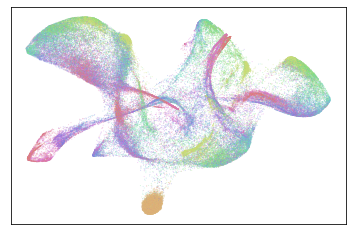

In [24]:
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
f = plt.figure()
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
#     palette=sns.color_palette("hls", 11),
    palette=a,
    data=df_subset,
    legend=False,
    alpha=0.3,
    s=1
)
plt.xlabel("")
plt.ylabel("")
plt.xticks([])
plt.yticks([])
plt.savefig("ensemble_2_color2.png",dpi=200)

([], [])

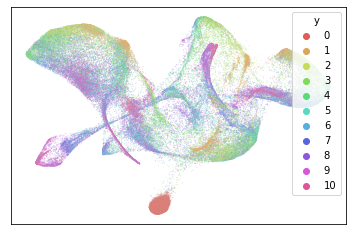

In [25]:
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
f = plt.figure()
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 11),
    data=df_subset,
    legend=True,
    alpha=0.3,
    s=1
)
plt.xlabel("")
plt.ylabel("")
plt.xticks([])
plt.yticks([])